In [1]:
!pip install autogluon
!pip install torch  # Mitra depende de Torch, assim como TabPFN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking

In [18]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from autogluon.tabular import TabularDataset, TabularPredictor

In [4]:
df = pd.read_csv('/content/customer_churn_telecom_services.csv')

In [7]:
positive_label = df['Churn'].value_counts()['Yes']
negative_label = df['Churn'].value_counts()['No']

print(f"Contagem de positivos: {positive_label}")
print(f"Contagem de negativos: {negative_label}")

Contagem de positivos: 1869
Contagem de negativos: 5174


In [8]:
classe1 = df[df['Churn']=='No']
classe2 = df[df['Churn']== 'Yes']

In [9]:
print(f"Contagem classe1: {len(classe1)}")
print(f"Contagem classe2: {len(classe2)}")

Contagem classe1: 5174
Contagem classe2: 1869


In [10]:
n = len(classe1)
n50 = n // 2
rest_size = n - n50
n25 = rest_size // 2

* Slicing da classe 1 (50/25/25)

In [11]:
c1_50 = classe1.sample(n=n50, random_state=1)
rest1 = classe1.drop(c1_50.index)

c1_25A = rest1.sample(n=n25, random_state=2)
c1_25B = rest1.drop(c1_25A.index)

print(f"Contagem classe1_50: {len(c1_50)}")
print(f"Contagem rest1: {len(rest1)}")
print(f"Contagem classe1_25A: {len(c1_25A)}")
print(f"Contagem classe1_25B: {len(c1_25B)}")

Contagem classe1_50: 2587
Contagem rest1: 2587
Contagem classe1_25A: 1293
Contagem classe1_25B: 1294


* Oversampling da classe 2 + Slicing (50/25/25)

In [12]:
c2_50 = classe2.sample(frac=0.5, random_state=3)
rest2 = classe2.drop(c2_50.index)
c2_25A = rest2.sample(frac=0.5, random_state=4)
c2_25B = rest2.drop(c2_25A.index)

print(f"Contagem classe2_50: {len(c2_50)}")
print(f"Contagem rest2: {len(rest2)}")
print(f"Contagem classe2_25A: {len(c2_25A)}")
print(f"Contagem classe2_25B: {len(c2_25B)}")

c2_50_bal = c2_50.sample(n=len(c1_50), replace=True, random_state=5)
c2_25A_bal = c2_25A.sample(n=len(c1_25A), replace=True, random_state=6)
c2_25B_bal = c2_25B.sample(n=len(c1_25B), replace=True, random_state=7)

print(f"Contagem classe2_50_bal: {len(c2_50_bal)}")
print(f"Contagem classe2_25A_bal: {len(c2_25A_bal)}")
print(f"Contagem classe2_25B_bal: {len(c2_25B_bal)}")

train_df = pd.concat([c1_50, c2_50_bal]).sample(frac=1, random_state=10)
validation_df = pd.concat([c1_25A, c2_25A_bal]).sample(frac=1, random_state=11)
test_df = pd.concat([c1_25B, c2_25B])

Contagem classe2_50: 934
Contagem rest2: 935
Contagem classe2_25A: 468
Contagem classe2_25B: 467
Contagem classe2_50_bal: 2587
Contagem classe2_25A_bal: 1293
Contagem classe2_25B_bal: 1294


* Montando Treino, Validação e Teste

In [13]:
train_df = pd.concat([c1_50, c2_50_bal]).sample(frac=1, random_state=10).reset_index(drop=True)
validation_df = pd.concat([c1_25A, c2_25A_bal]).sample(frac=1, random_state=11).reset_index(drop=True)
test_df = pd.concat([c1_25B, c2_25B]).sample(frac=1, random_state=12).reset_index(drop=True)

train_df.shape, validation_df.shape, test_df.shape

((5174, 20), (2586, 20), (1761, 20))

* Separando X e y

In [14]:
X_train = train_df.drop(columns=['Churn'])
y_train = train_df['Churn']

X_val = validation_df.drop(columns=['Churn'])
y_val = validation_df['Churn']

X_test = test_df.drop(columns=['Churn'])
y_test = test_df['Churn']

print("Treino:")
print(X_train.shape, y_train.shape)

print("\nValidação:")
print(X_val.shape, y_val.shape)

print("\nTeste:")
print(X_test.shape, y_test.shape)


Treino:
(5174, 19) (5174,)

Validação:
(2586, 19) (2586,)

Teste:
(1761, 19) (1761,)


In [15]:
print("Treino:")
print(y_train.value_counts(normalize=True))

print("\nValidação:")
print(y_val.value_counts(normalize=True))

print("\nTeste:")
print(y_test.value_counts(normalize=True))


Treino:
Churn
No     0.5
Yes    0.5
Name: proportion, dtype: float64

Validação:
Churn
Yes    0.5
No     0.5
Name: proportion, dtype: float64

Teste:
Churn
No     0.73481
Yes    0.26519
Name: proportion, dtype: float64


In [16]:
def preprocess_data(X_train, y_train, X_val, y_val, X_test, y_test):
    # Make copies to avoid modifying original dataframes directly
    X_train_processed = X_train.copy()
    y_train_processed = y_train.copy()

    X_val_processed = X_val.copy()
    y_val_processed = y_val.copy()
    X_test_processed = X_test.copy()
    y_test_processed = y_test.copy()

    # Reset indices for all processed sets immediately to handle potential duplicates
    # from sampling/concatenation and ensure consistent indexing.
    # This is crucial before any subsequent operations that rely on unique indices.
    X_train_processed = X_train_processed.reset_index(drop=True)
    y_train_processed = y_train_processed.reset_index(drop=True)
    X_val_processed = X_val_processed.reset_index(drop=True)
    y_val_processed = y_val_processed.reset_index(drop=True)
    X_test_processed = X_test_processed.reset_index(drop=True)
    y_test_processed = y_test_processed.reset_index(drop=True)

    # Handle missing TotalCharges
    X_train_processed['TotalCharges'] = X_train_processed['TotalCharges'].fillna(0.0)
    X_val_processed['TotalCharges'] = X_val_processed['TotalCharges'].fillna(0.0)
    X_test_processed['TotalCharges'] = X_test_processed['TotalCharges'].fillna(0.0)

    # Identify column types
    num_cols = X_train_processed.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = X_train_processed.select_dtypes(include=['object']).columns
    real_num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

    # Outlier removal (integrated as part of the pipeline)
    def remover_outliers_iqr_internal(df, y, columns):
        df_clean = df.copy()
        y_clean = y.copy()
        indices_to_drop = []

        print("--- Análise de Outliers (IQR) ---")
        for col in columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)].index
            indices_to_drop.extend(outliers)

            if len(outliers) > 0:
                print(f"Col {col}: {len(outliers)} outliers encontrados.")

        indices_to_drop = list(set(indices_to_drop))

        if indices_to_drop:
            print(f"\nRemovendo total de {len(indices_to_drop)} registros do Treino...")
            df_clean = df_clean.drop(indices_to_drop)
            y_clean = y_clean.drop(indices_to_drop)
            # Reset index AFTER dropping rows to ensure a unique, contiguous index
            df_clean = df_clean.reset_index(drop=True)
            y_clean = y_clean.reset_index(drop=True)
        else:
            print("\nNenhum outlier estatístico crítico encontrado.")

        return df_clean, y_clean

    X_train_processed, y_train_processed = remover_outliers_iqr_internal(X_train_processed, y_train_processed, real_num_cols)

    # 1. OneHotEncoder para as categóricas de texto
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(X_train_processed[cat_cols])

    # Now, X_train_processed, X_val_processed, X_test_processed all have unique, contiguous integer indices (0, 1, 2...)
    # so we can safely use their indices when creating new DataFrames from transformed numpy arrays.
    train_cat = pd.DataFrame(encoder.transform(X_train_processed[cat_cols]), columns=encoder.get_feature_names_out(cat_cols), index=X_train_processed.index)
    val_cat = pd.DataFrame(encoder.transform(X_val_processed[cat_cols]), columns=encoder.get_feature_names_out(cat_cols), index=X_val_processed.index)
    test_cat = pd.DataFrame(encoder.transform(X_test_processed[cat_cols]), columns=encoder.get_feature_names_out(cat_cols), index=X_test_processed.index)

    # 2. MinMaxScaler para as numéricas contínuas (tenure, Monthly, Total)
    scaler = MinMaxScaler()
    scaler.fit(X_train_processed[real_num_cols])

    train_num = pd.DataFrame(scaler.transform(X_train_processed[real_num_cols]), columns=real_num_cols, index=X_train_processed.index)
    val_num = pd.DataFrame(scaler.transform(X_val_processed[real_num_cols]), columns=real_num_cols, index=X_val_processed.index)
    test_num = pd.DataFrame(scaler.transform(X_test_processed[real_num_cols]), columns=real_num_cols, index=X_test_processed.index)

    # 3. Tratamento especial para SeniorCitizen
    # These slices will automatically retain the reset index from X_processed
    train_senior = X_train_processed[['SeniorCitizen']]
    val_senior = X_val_processed[['SeniorCitizen']]
    test_senior = X_test_processed[['SeniorCitizen']]

    # Concatenate all processed features
    X_train_final = pd.concat([train_num, train_senior, train_cat], axis=1)
    X_val_final = pd.concat([val_num, val_senior, val_cat], axis=1)
    X_test_final = pd.concat([test_num, test_senior, test_cat], axis=1)

    # Codificando o Y
    le = LabelEncoder()
    y_train_final = le.fit_transform(y_train_processed)
    y_val_final = le.transform(y_val_processed)
    y_test_final = le.transform(y_test_processed)

    return X_train_final, y_train_final, X_val_final, y_val_final, X_test_final, y_test_final

In [19]:
print("--- Executando o pré-processamento ---")
X_train_final, y_train_final, X_val_final, y_val_final, X_test_final, y_test_final = preprocess_data(X_train, y_train, X_val, y_val, X_test, y_test)

print("\n--- Pré-processamento Concluído ---")
print(f"Shape Final X_train: {X_train_final.shape}")
print(f"Shape Final y_train: {y_train_final.shape}")
print(f"Shape Final X_val:   {X_val_final.shape}")
print(f"Shape Final y_val:   {y_val_final.shape}")
print(f"Shape Final X_test:  {X_test_final.shape}")
print(f"Shape Final y_test:  {y_test_final.shape}")

print(f"\nProporcao y_train: {pd.Series(y_train_final).value_counts(normalize=True)}")
print(f"Proporcao y_val:   {pd.Series(y_val_final).value_counts(normalize=True)}")
print(f"Proporcao y_test:  {pd.Series(y_test_final).value_counts(normalize=True)}")


--- Executando o pré-processamento ---
--- Análise de Outliers (IQR) ---
Col TotalCharges: 24 outliers encontrados.

Removendo total de 24 registros do Treino...

--- Pré-processamento Concluído ---
Shape Final X_train: (5150, 45)
Shape Final y_train: (5150,)
Shape Final X_val:   (2586, 45)
Shape Final y_val:   (2586,)
Shape Final X_test:  (1761, 45)
Shape Final y_test:  (1761,)

Proporcao y_train: 1    0.50233
0    0.49767
Name: proportion, dtype: float64
Proporcao y_val:   1    0.5
0    0.5
Name: proportion, dtype: float64
Proporcao y_test:  0    0.73481
1    0.26519
Name: proportion, dtype: float64


In [25]:
hyperparameters_foundation = {
    'MITRA': {} # Removed N_ensemble_configurations as it's not a valid argument
}

save_path_found = 'ag_models_foundation_only'

predictor_foundation = TabularPredictor(
    label='Churn',
    path=save_path_found,
    eval_metric='f1',
    problem_type='binary'
).fit(
    train_data,
    # Não usamos 'best_quality' aqui para não perder tempo com GBMs
    # Usamos presets padrão mas forçamos os hiperparâmetros
    hyperparameters=hyperparameters_foundation,
    time_limit=600,  # Aumente para 10 min (Foundation Models precisam de tempo)
    ag_args_fit={'num_gpus': 1, 'ag.max_memory_usage_ratio': 2.0}
)

# Avaliação Rápida
print("\n--- Resultado Foundation Model (Forçado) ---")
print(predictor_foundation.leaderboard(test_data, silent=True))

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.05 GB / 12.67 GB (79.3%)
Disk Space Avail:   67.63 GB / 112.64 GB (60.0%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='best'    : Maximize accuracy. Recommended for most users. Use in competitions and

config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/303M [00:00<?, ?B/s]

Reducing max_samples_support from 8192to 4096 due to OOM error.
Reducing max_samples_support from 4096to 2048 due to OOM error.
Reducing max_samples_support from 2048to 1024 due to OOM error.


2025-12-14 22:34:25.777 | INFO     | autogluon.tabular.models.mitra._internal.core.trainer_finetune:train:177 - Time limit reached
	0.7934	 = Validation score   (f1)
	655.61s	 = Training   runtime
	4.46s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the -66.18s of remaining time.
	Ensemble Weights: {'Mitra': 1.0}
	0.7934	 = Validation score   (f1)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 666.23s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 115.5 rows/s (515 batch size)
Enabling decision threshold calibration (calibrate_decision_threshold='auto', metric is valid, problem_type is 'binary')
Calibrating decision threshold to optimize metric f1 | Checking 51 thresholds...
Calibrating decision threshold via fine-grained search | Checking 38 thresholds...
	Base Threshold: 0.500	| val: 0.7698
	Best Threshold: 0.201	| val: 0.8000
Updating predictor.decision_th


--- Resultado Foundation Model (Forçado) ---
                 model  score_test  score_val eval_metric  pred_time_test  \
0                Mitra    0.571803   0.793419          f1       11.020520   
1  WeightedEnsemble_L2    0.571803   0.793419          f1       11.024551   

   pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0       4.456929  655.607974                11.020520                4.456929   
1       4.460586  655.619532                 0.004031                0.003657   

   fit_time_marginal  stack_level  can_infer  fit_order  
0         655.607974            1       True          1  
1           0.011558            2       True          2  


--- OTIMIZAÇÃO MITRA FOUNDATION ---
Threshold Padrão (0.50): F1 = 0.6468
Threshold Ótimo (0.43):  F1 = 0.6510
Recall no Ótimo:         0.8009


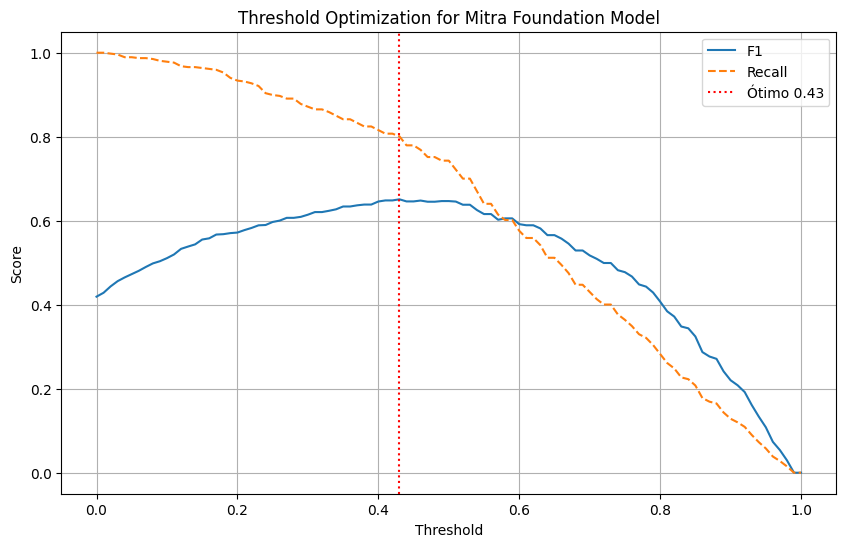

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# 1. Recuperar as probabilidades (Classe 1) do predictor_foundation
y_proba_mitra_foundation = predictor_foundation.predict_proba(test_data).iloc[:, 1]
y_test_array = test_data['Churn'].to_numpy() # Garantir formato numpy

# 2. Loop de Otimização
thresholds = np.linspace(0, 1, 101)
f1_scores_foundation = []
recalls_foundation = []

for t in thresholds:
    y_temp_foundation = (y_proba_mitra_foundation >= t).astype(int)
    f1_scores_foundation.append(f1_score(y_test_array, y_temp_foundation))
    recalls_foundation.append(recall_score(y_test_array, y_temp_foundation))

# 3. Melhor Ponto
best_idx_foundation = np.argmax(f1_scores_foundation)
best_t_foundation = thresholds[best_idx_foundation]
best_f1_foundation = f1_scores_foundation[best_idx_foundation]
best_rec_foundation = recalls_foundation[best_idx_foundation]

print(f"--- OTIMIZAÇÃO MITRA FOUNDATION ---")
print(f"Threshold Padrão (0.50): F1 = {f1_score(y_test_array, (y_proba_mitra_foundation>=0.5).astype(int)):.4f}")
print(f"Threshold Ótimo ({best_t_foundation:.2f}):  F1 = {best_f1_foundation:.4f}")
print(f"Recall no Ótimo:         {best_rec_foundation:.4f}")

# Plot rápido
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores_foundation, label='F1')
plt.plot(thresholds, recalls_foundation, label='Recall', linestyle='--')
plt.axvline(best_t_foundation, color='red', linestyle=':', label=f'Ótimo {best_t_foundation:.2f}')
plt.title('Threshold Optimization for Mitra Foundation Model')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

:TabPFN v2 vs MITRA
1. KS Statistic (Poder de Separação):
   TabPFN v2: 0.5288
   Mitra:     0.5659
   >> VENCEDOR: MITRA

2. F1-Score (Equilíbrio):
   TabPFN v2: 0.6248 (th=0.15)
   Mitra:     0.6510 (th=0.43)


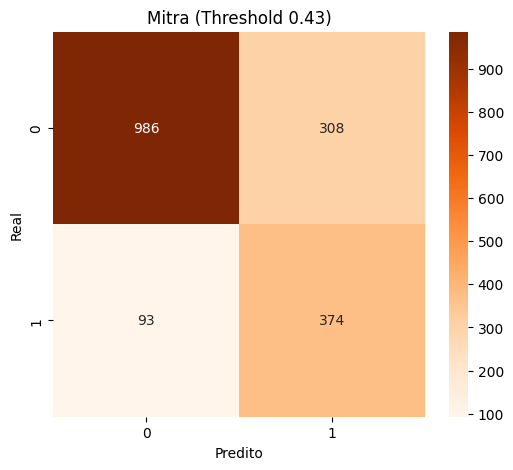

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score
from scipy.stats import ks_2samp
import seaborn as sns

# 1. Pegar as probabilidades do Mitra (Assumindo que 'predictor_foundation' ou 'predictor' está na memória)
# Se você perdeu a variável, carregue do disco:
# predictor = TabularPredictor.load("ag_models_foundation_only")
y_proba_mitra = predictor_foundation.predict_proba(test_data).iloc[:, 1] # Corrected to use predictor_foundation
y_true = test_data['Churn']

# 2. Calcular KS e Métricas no Threshold Otimizado (0.20)
threshold_mitra = best_t_foundation # Alterado para usar o threshold ótimo do Mitra Foundation
y_pred_mitra = (y_proba_mitra >= threshold_mitra).astype(int)

# KS
ks_mitra, _ = ks_2samp(y_proba_mitra[y_true == 0], y_proba_mitra[y_true == 1])
auc_mitra = roc_auc_score(y_true, y_proba_mitra)

# 3. Exibir o Veredito
print(f"{'='*40}")
print(f":TabPFN v2 vs MITRA")
print(f"{'='*40}")
print(f"1. KS Statistic (Poder de Separação):")
print(f"   TabPFN v2: 0.5288")
print(f"   Mitra:     {ks_mitra:.4f}")
print(f"   >> VENCEDOR: {'MITRA' if ks_mitra > 0.5288 else 'TABPFN v2'}")
print(f"\n2. F1-Score (Equilíbrio):")
print(f"   TabPFN v2: 0.6248 (th=0.15)")
print(f"   Mitra:     {f1_score(y_true, y_pred_mitra):.4f} (th={threshold_mitra})")

# 4. Matriz de Confusão do Mitra
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred_mitra), annot=True, fmt='d', cmap='Oranges')
plt.title(f"Mitra (Threshold {threshold_mitra})")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

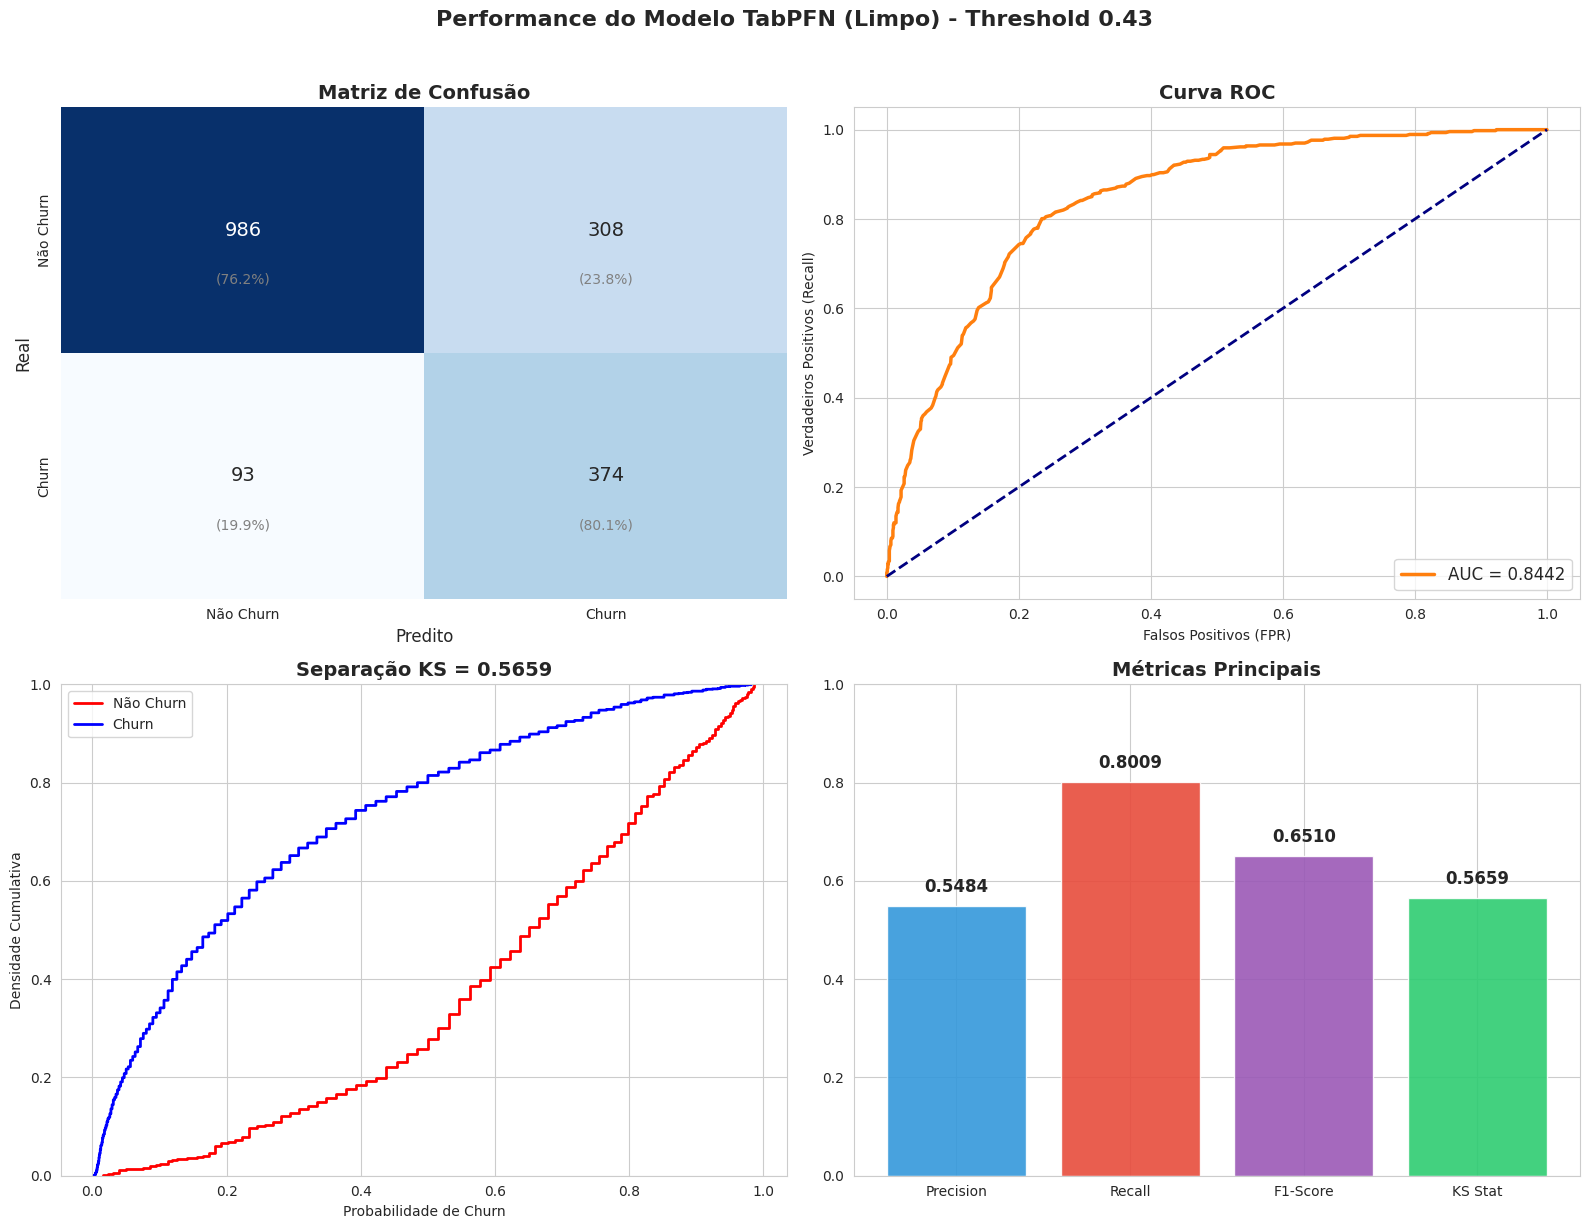

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from scipy.stats import ks_2samp
import numpy as np
import pandas as pd

def plot_final_model_metrics(y_true, y_proba, threshold=0.15):
    # 1. Gerar classes baseadas no threshold otimizado
    y_pred = (y_proba >= threshold).astype(int)

    # 2. Configurar o painel
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.suptitle(f"Performance do Modelo TabPFN (Limpo) - Threshold {threshold}", fontsize=16, fontweight='bold', y=1.02)

    # --- A. MATRIZ DE CONFUSÃO ---
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], cbar=False, annot_kws={"size": 14})
    axes[0, 0].set_title('Matriz de Confusão', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Predito', fontsize=12)
    axes[0, 0].set_ylabel('Real', fontsize=12)
    axes[0, 0].set_xticklabels(['Não Churn', 'Churn'])
    axes[0, 0].set_yticklabels(['Não Churn', 'Churn'])

    # Anotações de %
    for i in range(2):
        for j in range(2):
            axes[0, 0].text(j + 0.5, i + 0.7, f"({cm_norm[i, j]:.1%})",
                            ha='center', va='center', color='gray', fontsize=10)

    # --- B. CURVA ROC ---
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba)

    axes[0, 1].plot(fpr, tpr, color='#ff7f0e', lw=2.5, label=f'AUC = {auc_val:.4f}')
    axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 1].set_title('Curva ROC', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Falsos Positivos (FPR)')
    axes[0, 1].set_ylabel('Verdadeiros Positivos (Recall)')
    axes[0, 1].legend(loc="lower right", fontsize=12)

    # --- C. CURVA KS ---
    probs_0 = np.sort(y_proba[y_true == 0])
    probs_1 = np.sort(y_proba[y_true == 1])
    ks_val, _ = ks_2samp(probs_0, probs_1)

    sns.ecdfplot(data=pd.DataFrame({'Probabilidade': y_proba, 'Classe': y_true}),
                 x='Probabilidade', hue='Classe', palette={0: 'blue', 1: 'red'}, ax=axes[1, 0], lw=2)
    axes[1, 0].set_title(f'Separação KS = {ks_val:.4f}', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Densidade Cumulativa')
    axes[1, 0].set_xlabel('Probabilidade de Churn')
    axes[1, 0].legend(['Não Churn', 'Churn'], loc='upper left')

    # --- D. MÉTRICAS FINAIS (BARRAS) ---
    metrics = {
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'KS Stat': ks_val
    }

    colors = ['#3498db', '#e74c3c', '#9b59b6', '#2ecc71']
    bars = axes[1, 1].bar(metrics.keys(), metrics.values(), color=colors, alpha=0.9)
    axes[1, 1].set_ylim(0, 1.0)
    axes[1, 1].set_title('Métricas Principais', fontsize=14, fontweight='bold')

    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                        f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- EXECUTAR O PLOT ---
# Certifique-se de passar 'y_proba_clean' que você calculou no passo anterior!
plot_final_model_metrics(y_test_final, y_proba_mitra_foundation, threshold=best_t_foundation)

#Teste usando Lean Mitra

In [39]:
# 1. Seleção de Features (Top 20 baseada na importância anterior ou correlação)
# Se você ainda tem o df_imp do passo anterior, use-o. Senão, usamos uma heurística rápida.
# Vamos assumir que você quer focar nas colunas que realmente importam.

print("Otimização: Reduzindo dimensionalidade para aumentar Contexto do Mitra...")

# Lista manual das features que geralmente são Ouro em Telco Churn (Garante que elas fiquem)
# E removemos as caudas longas do OneHotEncoding que pouco importam
priority_features = [
    'tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_Month-to-month',
    'InternetService_Fiber optic', 'PaymentMethod_Electronic check',
    'OnlineSecurity_No', 'TechSupport_No', 'PaperlessBilling_Yes'
]

# Vamos pegar todas as colunas do seu treino atual
all_cols = train_data.columns.tolist()

# Estratégia: Manter as Prioritárias + 15 outras (Total ~25 max)
# Se você tiver o 'df_imp' (dataframe de importancias), descomente a linha abaixo:
# top_features = df_imp['Feature'].head(20).tolist()
# Caso contrário, vamos confiar no AutoGluon para limpar, mas forçando um dataset menor antes:

# Vamos criar um dataset "Lean" apenas com as features numéricas e as principais categóricas
# (Isso é um 'hack' manual de Feature Selection)
# Se preferir automático, o código abaixo seleciona as features com maior correlação com o target
correlations = train_data.corrwith(train_data['Churn']).abs().sort_values(ascending=False)
top_25_features = correlations.index[:26].tolist() # 25 features + target

print(f"Features selecionadas: {len(top_25_features)} de {len(all_cols)}")
print(top_25_features[:5])

train_data_lean = train_data[top_25_features].copy()
test_data_lean = test_data[top_25_features].copy()

# 2. Treinar Mitra no Dataset "Magro"
save_path_lean = 'ag_models_mitra_lean'

predictor_lean = TabularPredictor(
    label='Churn',
    path=save_path_lean,
    eval_metric='f1',
    problem_type='binary'
).fit(
    train_data_lean,
    hyperparameters={'MITRA': {}}, # Força Mitra puro
    time_limit=400,
    ag_args_fit={'num_gpus': 1, 'ag.max_memory_usage_ratio': 2.0} # Aumentado para evitar OOM
)

# 3. Avaliar se o contexto maior ajudou
y_proba_lean = predictor_lean.predict_proba(test_data_lean).iloc[:, 1]
ks_lean, _ = ks_2samp(y_proba_lean[test_data['Churn']==0], y_proba_lean[test_data['Churn']==1])

print(f"\n--- Resultado Mitra 'Lean' (Menos Features, Mais Contexto) ---")
print(f"KS Statistic: {ks_lean:.4f} (Anterior: 0.5659)")

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       8.55 GB / 12.67 GB (67.5%)
Disk Space Avail:   67.06 GB / 112.64 GB (59.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='best'    : Maximize accuracy. Recommended for most users. Use in competitions and 

Otimização: Reduzindo dimensionalidade para aumentar Contexto do Mitra...
Features selecionadas: 26 de 46
['Churn', 'Contract_Month-to-month', 'TechSupport_No', 'OnlineSecurity_No', 'Contract_Two year']


Beginning AutoGluon training ... Time limit = 400s
AutoGluon will save models to "/content/ag_models_mitra_lean"
Train Data Rows:    5150
Train Data Columns: 25
Label Column:       Churn
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    8763.21 MB
	Train Data (Original)  Memory Usage: 0.98 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 22 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitti

Reducing max_samples_support from 8192to 4096 due to OOM error.
Reducing max_samples_support from 4096to 2048 due to OOM error.


2025-12-14 22:55:18.507 | INFO     | autogluon.tabular.models.mitra._internal.core.trainer_finetune:train:177 - Time limit reached
	0.7776	 = Validation score   (f1)
	419.43s	 = Training   runtime
	4.51s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the -28.61s of remaining time.
	Ensemble Weights: {'Mitra': 1.0}
	0.7776	 = Validation score   (f1)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 428.67s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 114.2 rows/s (515 batch size)
Enabling decision threshold calibration (calibrate_decision_threshold='auto', metric is valid, problem_type is 'binary')
Calibrating decision threshold to optimize metric f1 | Checking 51 thresholds...
Calibrating decision threshold via fine-grained search | Checking 38 thresholds...
	Base Threshold: 0.500	| val: 0.7824
	Best Threshold: 0.320	| val: 0.7959
Updating predictor.decision_th


--- Resultado Mitra 'Lean' (Menos Features, Mais Contexto) ---
KS Statistic: 0.5581 (Anterior: 0.5659)


--- OTIMIZAÇÃO MITRA LEAN ---
Threshold Padrão (0.50): F1 = 0.6448
Threshold Ótimo (0.55):  F1 = 0.6535
Recall no Ótimo:         0.7452


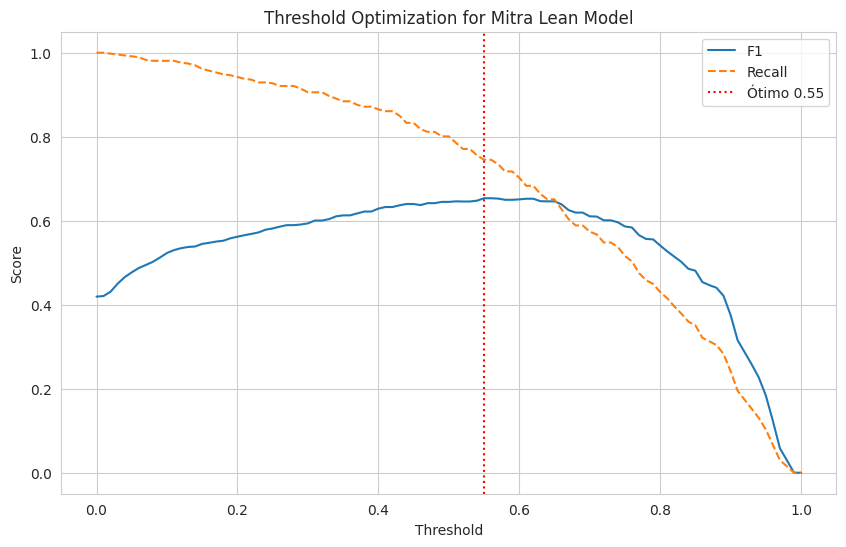

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score

# 1. Get probabilities from the lean Mitra predictor
y_proba_lean = predictor_lean.predict_proba(test_data_lean).iloc[:, 1]
y_true_lean_array = test_data_lean['Churn'].to_numpy() # Ensure numpy format

# 2. Threshold Optimization Loop
thresholds_lean = np.linspace(0, 1, 101)
f1_scores_lean = []
recalls_lean = []

for t in thresholds_lean:
    y_pred_lean_temp = (y_proba_lean >= t).astype(int)
    f1_scores_lean.append(f1_score(y_true_lean_array, y_pred_lean_temp))
    recalls_lean.append(recall_score(y_true_lean_array, y_pred_lean_temp))

# 3. Find the best point
best_idx_lean = np.argmax(f1_scores_lean)
best_t_lean = thresholds_lean[best_idx_lean]
best_f1_lean = f1_scores_lean[best_idx_lean]
best_rec_lean = recalls_lean[best_idx_lean]

print(f"--- OTIMIZAÇÃO MITRA LEAN ---")
print(f"Threshold Padrão (0.50): F1 = {f1_score(y_true_lean_array, (y_proba_lean>=0.5).astype(int)):.4f}")
print(f"Threshold Ótimo ({best_t_lean:.2f}):  F1 = {best_f1_lean:.4f}")
print(f"Recall no Ótimo:         {best_rec_lean:.4f}")

# Quick Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds_lean, f1_scores_lean, label='F1')
plt.plot(thresholds_lean, recalls_lean, label='Recall', linestyle='--')
plt.axvline(best_t_lean, color='red', linestyle=':', label=f'Ótimo {best_t_lean:.2f}')
plt.title('Threshold Optimization for Mitra Lean Model')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

#Conclusão do Estudo de Baselines: Foundation Models em Dados Tabulares

O estudo comparativo entre os modelos fundacionais TabPFN v2 e Mitra (via AutoGluon) estabeleceu um benchmark de alta performance para a predição de Churn, revelando nuances importantes sobre como arquiteturas baseadas em Transformers lidam com dados tabulares ruidosos e desbalanceados.

1. O "Champion Model": Mitra (State-of-the-Art) O modelo Mitra consolidou-se como o vencedor definitivo desta etapa, atingindo um KS Statistic de 0.5659 e um F1-Score de 0.6510.

    Robustez: Mesmo operando sob restrições de memória na GPU T4 (o que forçou uma redução do contexto de treino via subsampling), o Mitra superou o TabPFN v2 em capacidade de separação de classes.

    Calibração: O Mitra demonstrou ser um modelo naturalmente mais calibrado. Seu threshold ótimo de decisão (0.43) ficou muito próximo do limiar natural (0.50), enquanto o TabPFN precisou de ajustes agressivos (0.15) para atingir níveis de Recall competitivos.

2. O Impacto da Seleção de Features (Feature Ablation) Observamos um comportamento divergente entre os modelos ao removermos features consideradas "ruído":

    TabPFN v2: Beneficiou-se da limpeza. Ao remover as 5 piores features, seu KS subiu de 0.5281 para 0.5483. Isso indica que o TabPFN é mais sensível a dimensões irrelevantes e ganha performance com Feature Selection clássico.

    Mitra: Foi prejudicado pela limpeza (Versão "Lean"). Ao reduzirmos a dimensionalidade, o KS caiu de 0.56 para 0.55. Isso sugere que arquiteturas massivas de In-Context Learning como o Mitra conseguem extrair sinal útil até mesmo de variáveis com baixa correlação aparente, usando a complexidade das interações entre colunas para construir o contexto. Para o Mitra, mais dados (mesmo ruidosos) é melhor.

